Introduction: The idea of this notebook is to display a proof of concept appliation of using Max-Cut recursively to determine quarantine groups among a target network/population, which minimizes the interaction between the groups. We first show the procedure on a toy example of a 30 regular graphs, and then take steps to make our models more realistic and closer to real world cases.

In [47]:
from collections import defaultdict
import numpy as np
from itertools import combinations
from dwave.system.samplers import DWaveSampler
from dwave.system import LeapHybridSampler
from dwave.system.composites import EmbeddingComposite
from matplotlib import pyplot as plt
import networkx as nx
import networkx.generators.community as community
from networkx.generators.random_graphs import connected_watts_strogatz_graph as small_world 
import ndlib
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.utils import multi_runs
from bokeh.palettes import Category20_9 as cols
import future.utils
import random
import warnings
from random import randint
warnings.simplefilter('ignore')
%matplotlib inline

### Max-Cut on D-Wave machines functions

In [41]:
def maxcut_qubo(G):
    """
    Generate a QUBO instance Q representing Max-Cut on G
    """
    Q = defaultdict(int)
    for u, v in G.edges:
        Q[(u,u)]+= -1
        Q[(v,v)]+= -1
        Q[(u,v)]+= 2
    return Q

def solve(Q, chainstrength=8, numruns=100):
    """
    Solve a QUBO Q on a D-Wave machine 
    """
    #sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True})) MOVED TO HYBRID SAMPLER
    sampler = LeapHybridSampler()
    response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
    energies = iter(response.data())
    return response.first

def brute_best(G):
    """
    Brute force calculate the highest possible Max-Cut cost function value on G
    """
    sub_lists = []
    for i in range(0, len(G.nodes())+1):
        temp = [list(x) for x in combinations(G.nodes(), i)]
        sub_lists.extend(temp)   
    # Calculate the cut_size for all possible cuts
    cut_size = []
    for sub_list in sub_lists:
        cut_size.append(nx.algorithms.cuts.cut_size(G,sub_list))
    return max(cut_size)

def binary_split(G, limit = 4, pos=None, infected_nodes=[], graph=False, print_progress=False, weighted=False):
    """ 
    Recursively call Max-Cut on graph G, splitting into groups until the size of each group reaches limit.
    infected_nodes, graph, pos, and print_progress allow for visualizing process
    weighted allows for weighted Max-Cut
    """

    if G.number_of_nodes() <= limit or G.number_of_edges() == 0: #recursion base case and if no edges D-Wave will error
        return [G]
    else: # split into two groups       
        if weighted == False:
            Q = maxcut_qubo(G)
        else:
            Q = weighted_maxcut_qubo(G)
        sol = solve(Q)
        
    labels = sol.sample
    for node in G.nodes: # D-Wave doesn't assign labels to isolated vertices so assign to 0
        if node not in labels:
            labels[node] = 0
    
    # assign all nodes labeled 0 to 'left' and all else to 'right.' Color left red, right blue, and infected green
    colors = ['g' if i in infected_nodes else ('r' if labels[i] == 0 else 'b') for i in G.nodes]
    left = [i for i in G.nodes if labels[i] == 0] 
    right = [i for i in G.nodes if labels[i] == 1]
    
    # graphing and reporting progress
    if graph:
        fig = plt.figure(constrained_layout=False)
        gs = fig.add_gridspec(nrows=2, ncols=3)
        gs.update(wspace=0, hspace=0)
        ax1 = fig.add_subplot(gs[:,:2])   
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax2 = fig.add_subplot(gs[0,2])  
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax3 = fig.add_subplot(gs[1,2]) 
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])    
    left_G = G.subgraph(left)
    right_G = G.subgraph(right)
    left_colors = ['g' if i in infected_nodes else 'r'  for i in left_G.nodes]
    right_colors = ['g' if i in infected_nodes else 'b' for i in right_G.nodes]
    if print_progress == True:
        print("Divided {} people into {} & {}".format(G.number_of_nodes(), left_G.number_of_nodes(), right_G.number_of_nodes()))    
    if graph:       
        if pos == None:
            pos = nx.spring_layout(G)
        nx.draw_networkx(G, node_size=300, alpha=.8, ax=ax1, pos=pos, node_color=colors)
        nx.draw_networkx(left_G, node_size=300, alpha=.8, ax=ax2, pos=pos, node_color=left_colors)
        nx.draw_networkx(right_G, node_size=300, alpha=.8, ax=ax3, pos=pos, node_color=right_colors)
    
    #recursively call Max-Cut on left and right groups
    group = []
    group.extend(binary_split(left_G,  limit=limit, pos=pos, infected_nodes=infected_nodes, 
                              graph=graph,print_progress=print_progress, weighted=weighted))    
    group.extend(binary_split(right_G, limit=limit, pos=pos, infected_nodes=infected_nodes, 
                              graph=graph, print_progress=print_progress, weighted=weighted))     
    
    return group

### Plotting functions

In [10]:
def plot_colorized_groups(G, groups, infected):
    """
    Visualize binary split by assigning a random color to each quarantine group in G
    """
    def n_random_colors(n):
        colors = []
        for i in range(n):
            colors.append('#%06X' % randint(0, 0xFFFFFF))
        return colors

    node_colors = [None for i in G.nodes]
    palette = n_random_colors(len(groups))
    for graph, color in zip(groups, palette):
        for node in graph.nodes:
            node_colors[node] = color
    for node in infected:
        node_colors[node] = 'red'

    pos = nx.spring_layout(G)
    fig = plt.figure(figsize=(6,6))
    default_axes = fig.add_subplot(frameon=True)
    nx.draw_networkx(G, node_size=400, alpha=1, node_color=node_colors)
    default_axes.set_title("")
    plt.show()

def plot(viz, ax, title):
    """
    Plot the spread of disease over time 
    viz: Data returned by virus simulations
    ax: axis to plot on
    group_status: title of plot
    """
    pres = viz.iteration_series(90)
    mx = 0
    i = 0
    for k, l in future.utils.iteritems(pres):
        mx = len(l[0])
        if viz.normalized:
            ax.plot(range(0, mx), l[1]/viz.nnodes, lw=2, label=viz.srev[k], alpha=0.5, color=cols[i])
            ax.fill_between(range(0,  mx), l[0]/viz.nnodes, l[2]/viz.nnodes, alpha=0.2, # had to change alpha to a float
                             color=cols[i])
        else:
            ax.plot(range(0, mx), l[1], lw=2, label=viz.srev[k], alpha=0.5, color=cols[i])
            ax.fill_between(range(0, mx), l[0], l[2], alpha=0.2, # had to change alpha to a float
                             color=cols[i])
        i += 1
    ax.grid(axis="y")
    ax.set_title(title)
    ax.set_xlabel("Iterations", fontsize=24)
    ax.set_ylabel(viz.ylabel, fontsize=24)
    ax.legend(loc="best", fontsize=18)
    ax.set_xlim((0, mx))

def plot_comparison(G, infected, r_infect=0.001, r_recover=0.01, iterations = 100, group_sizes = [4,16], weighted = False):    
    """
    Plot side by side comparisons of disease spread in the quarantined and un-quarantined cases for groups of size
    given by group_sizes and determined by binary_split
    """
    original_model, original_trends, _ = sim_virus(G, infected_nodes = infected, iteration = iterations, 
                                                   r_infect = r_infect, r_recover=r_recover)
    original_viz = DiffusionTrend(original_model, original_trends)
    for l in group_sizes:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        groups = binary_split(G, infected_nodes = infected, limit = l, weighted = weighted)
        model, trends = sim_virus_group(G, groups, original_model, r_infect = r_infect, r_recover = r_recover,
                                        original_infected_nodes = infected, iteration = iterations)
        viz = DiffusionTrend(model, trends)
        plot(viz, ax[0], "Quarantined groups of size >= {}".format(l) )
        plot(original_viz, ax[1], 'No Quarantine')

### Epidemic Modelling functions

In [11]:
def sim_virus(G, r_infect=0.001, r_recover=0.01, infected_nodes = [], iteration=500):
    """
    Simulates virus spread on entire graph G with initial infected nodes and disease properties
    iteration: number of steps of virus spread
    returns: model, trends: dictionary indexed by number of susceptible (0), infected (1) and removed (2) nodes
    iterations: dictionary indexed by iteration, containing the state of every node at that iteration
    https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html
    """
    model = ep.SIRModel(G)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', r_infect) # infection rate
    cfg.add_model_parameter('gamma', r_recover) # recovery rate
    cfg.add_model_initial_configuration("Infected", infected_nodes)
    model.set_initial_status(cfg)
    iterations = model.iteration_bunch(iteration, node_status=False)
    trends = model.build_trends(iterations)     
    return model, trends, iterations 


def sim_virus_group(G, groups, original_model, r_infect=0.001, r_recover=0.01, original_infected_nodes = [], iteration=500):
    """
    Simulate virus spread in each quarantined group in groups seperately, 
    Aggregate virus spread in each group to whole population and return stats
    """
    net_trends = {'trends': {'node_count': {0:[0]*iteration, 1:[0]*iteration, 2:[0]*iteration}}}
    for g in groups:
        model, trends, iterations = sim_virus(g, r_infect, r_recover, [n for n in original_infected_nodes if n in g.nodes], iteration)
        for idx,i in enumerate(iterations):
            i_count = i['node_count']
            for jk, jv in i_count.items():
                net_trends['trends']['node_count'][jk][idx] += jv
    for i in range(iteration):
        ctr = net_trends['trends']['node_count'][0][i]+net_trends['trends']['node_count'][1][i]+net_trends['trends']['node_count'][2][i]
        assert ctr == len(G.nodes), (ctr,i)
    return original_model, [net_trends]


# Test on 30 node complete graph toy example

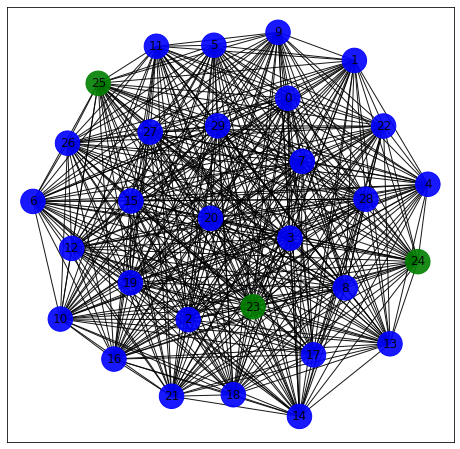

In [14]:
n = 30
init_infect = 0.1
G = nx.generators.classic.complete_graph(n)
pos = nx.spring_layout(G)
fig = plt.figure(figsize=(8,8))
default_axes = fig.add_subplot(frameon=True)
infected = np.random.choice(range(n), int(n*init_infect), replace=False)
colors = ['g' if i in infected else 'b' for i in G.nodes]
nx.draw_networkx(G, node_size=600, alpha=.9, node_color=colors)
plt.show()

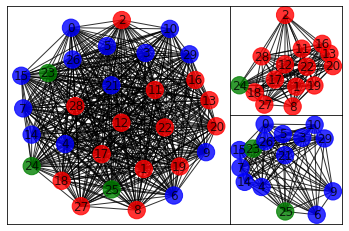

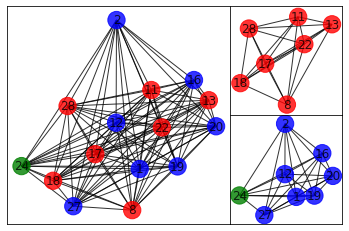

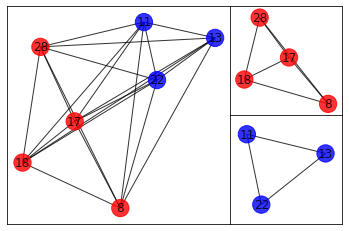

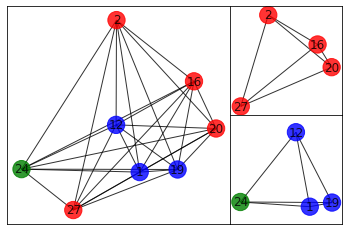

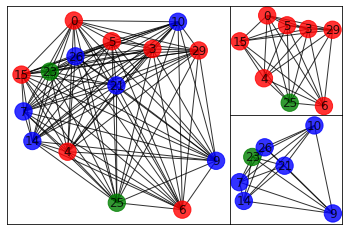

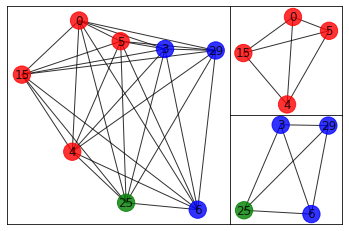

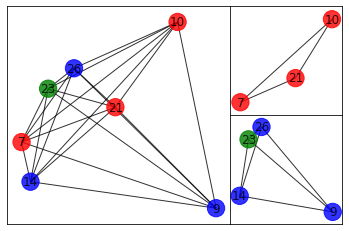

In [15]:
groups = binary_split(G, infected_nodes = infected, limit = 4, graph = True)

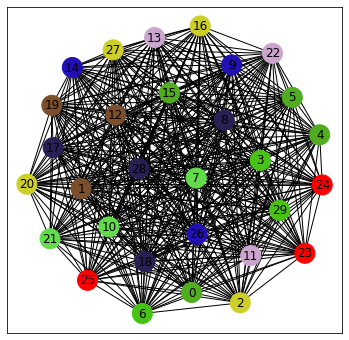

infected people are red


In [16]:
plot_colorized_groups(G, groups, infected)
print('infected people are red')

100%|████████████████████████████████████████████| 600/600 [00:00<00:00, 3100.67it/s]


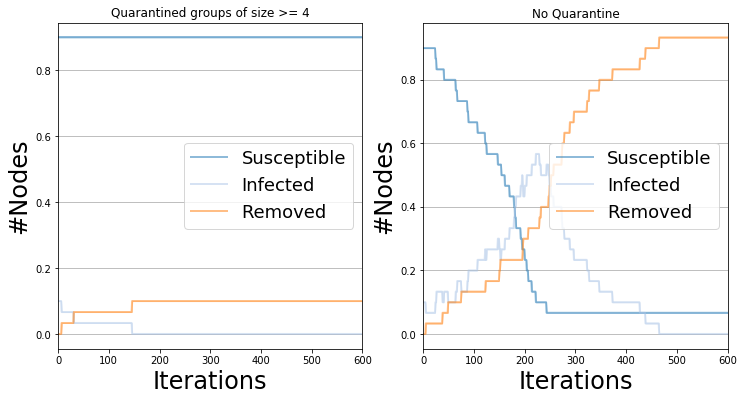

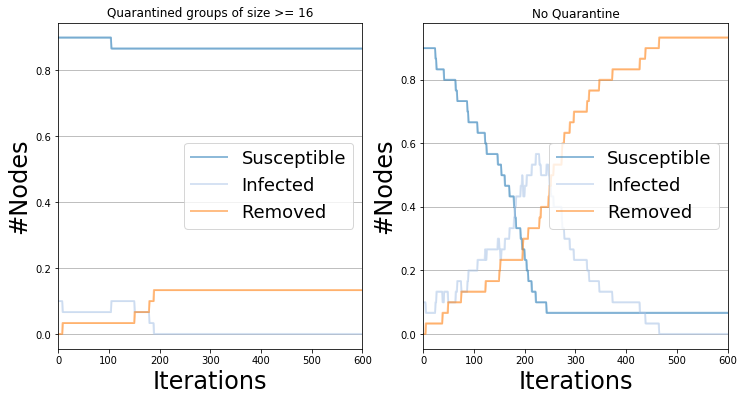

In [18]:
# Lets try plotting the comparison
plot_comparison(G, infected, iterations = 600)

A brief note on interpreting these graphs: The removed value at equilibrium (flat lines) tells you the total fraction of infected people at the end of the virus spread process. The highest point on the infected curve tells you the "peak" of the spread. In heath care we may want to reduce total infections or "flatten the curve" which refer to each of these, respectively.

Observations:

We would need to actually look more into the trends, but I'm guessing that whats happening here is that in the grouped into >=4 case, we have around 7 or 8 groups, and in some of them the growth blows up too fast, infecting the whole group, while in others, the growth dies off. Since the groups are entirely isolated and small, this all happens within the first 50 iterations, and then every one either recovers or remains not sick. This is why the rates become constant, I dont think that it's a bug. Ideally, if everyone was individually quarantined the rates would be constant the whole time, because at point of quarantine either you have it or you dont, so it wouldnt change, which is what we expect/want actually.

## Questions

###### 1) Can you find more reasonable graph? 

https://docs.google.com/document/d/1sIhKVY2pnwngybutyI44d0tuzlTnAOyHB3FnjxcpAr8/edit 
Notes for this question can be found here
In summary, we are looking for a sparse watts-strogatz (small-world) network for college campuses

As a next step we should try to figure out how to make one node possibly part of more than one community, since a person can be part of school, family, friend group, sport team etc...

Also, we have a notebook testing properties of various networkx graph generators in this folder as:

"Testing Networkx Graph Generators.ipynb"

###### 2) What are the correct r_infect and r_recover rates to use for a given graph?

See "Testing SIR epidemic Spread model on Small-World Graphs.ipynb." 

Gives r_infect = .6/avg_degree(G) and r_recover = .1

###### 3) How much better is a D-Wave max-cut grouping than a random grouping?

We will test this below

###### 4) Can you make the cut dependent on the infected people rather than blindly separating?

Possible solution: weight every edge connecting an infected person to a non-infected and non-recovered person by (constant/#nodes) so that the edge is likely to be cut NOTE: This assumes everybody is tested with accuracy and is knowledgeble of their evolving condition in real time, this is not the case in the US but seems to be in some countries like South Korea, Iceland. It may be the case that it would make sense to either remove an infected vertex from the algo to begin with, or use D-Wave built in fixed variables. ALSO, infected nodes could be isolated a priori, so it may not be as fruitful to think about this case.

### Answering Q3  Using watts_strogatz networks

In [25]:
def avg_degree(G):
    return 2 * G.number_of_edges() / G.number_of_nodes()

In [33]:
cornell_approx_n = 3800
cornell_approx = small_world(cornell_approx_n, 152, .15) # parameters explained in "Testing Networkx Graph Generators"
cornell_approx_init_infect = 0.1
cornell_approx_infected = np.random.choice(range(cornell_approx_n), int(cornell_approx_n*cornell_approx_init_infect), 
                                           replace=False)
cornell_approx_avg_degree = avg_degree(cornell_approx)

In [44]:
# Just testing if splitting works before calling plot_comparison
groups = binary_split(cornell_approx, infected_nodes = cornell_approx_infected, limit = 500, print_progress = True)

Divided 3800 people into 1901 & 1899
Divided 1901 people into 948 & 953
Divided 948 people into 471 & 477
Divided 953 people into 475 & 478
Divided 1899 people into 951 & 948
Divided 951 people into 474 & 477
Divided 948 people into 474 & 474


100%|██████████████████████████████████████████████| 200/200 [00:06<00:00, 32.26it/s]


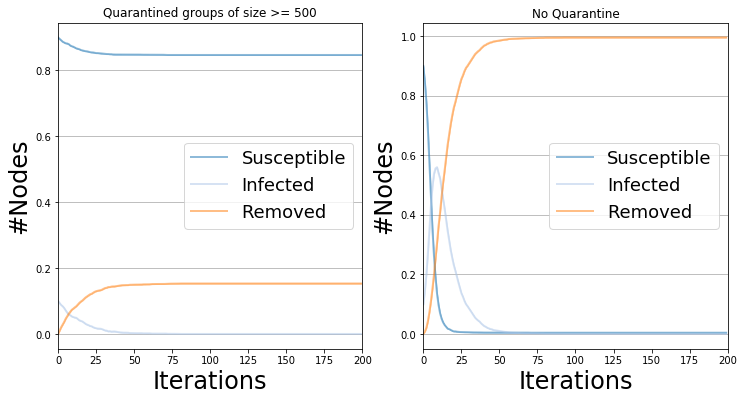

In [45]:
plot_comparison(cornell_approx, cornell_approx_infected, r_infect = .6/cornell_approx_avg_degree, 
                r_recover = .1, group_sizes = [500], iterations = 100)

This looks promising, but let's compare it to a case of randomly breaking the population into 8 quarantine groups as a control

In [76]:
def plot_random_unquarantined_comparison(G, infected, num_groups_list=[8], r_infect=0.001, r_recover=0.01, iterations = 100, weighted = False):    
    """
    Plot side by side comparisons of disease spread in the quarantined and un-quarantined cases for groups of size
    given by group_sizes and determined by randomized group assignment
    """
    original_model, original_trends, _ = sim_virus(G, infected_nodes = infected, iteration = iterations, 
                                                   r_infect = r_infect, r_recover=r_recover)
    original_viz = DiffusionTrend(original_model, original_trends)
    for num_groups in num_groups_list:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        group_nodes = [[] for _ in range(num_groups)]
        for person in range(G.number_of_nodes()):
            random.choice(group_nodes).append(person)
        group_graphs = [nx.Graph.subgraph(G, nodes) for nodes in group_nodes]
        model, trends = sim_virus_group(G, group_graphs, original_model, r_infect = r_infect, r_recover = r_recover,
                                        original_infected_nodes = infected, iteration = iterations)
        viz = DiffusionTrend(model, trends)
        plot(viz, ax[0], "Randomly Quarantined groups of size >= {}".format(G.number_of_nodes()/num_groups) )
        plot(original_viz, ax[1], 'No Quarantine')

  7%|███▎                                            | 7/100 [00:00<00:02, 35.48it/s]

[486, 517, 505, 494, 441, 454, 439, 464]


100%|██████████████████████████████████████████████| 100/100 [00:03<00:00, 32.46it/s]


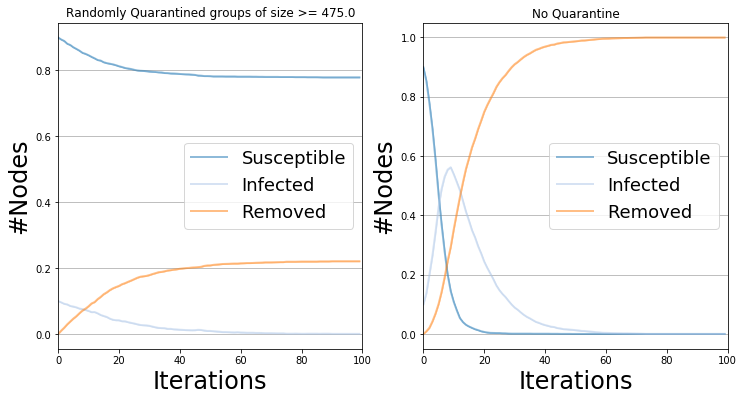

In [77]:
plot_random_unquarantined_comparison(cornell_approx, cornell_approx_infected, num_groups_list=[8], r_infect = .6/cornell_approx_avg_degree, 
                r_recover = .1, iterations = 100)

This result shows that random quarantining also works really well for small world networks, suggesting that we need to try to more closely compare the efficacy of quantum vs random quarantining

In [91]:
def plot_random_quantum_comparison(G, infected, group_sizes=[250, 500, 1000], r_infect=0.001, r_recover=0.01, iterations = 100, weighted = False):    
    """
    Plot side by side comparisons of disease spread in the quarantined and un-quarantined cases for groups of size
    given by group_sizes and determined by randomized group assignment
    """
    original_model, original_trends, _ = sim_virus(G, infected_nodes = infected, iteration = iterations, 
                                                   r_infect = r_infect, r_recover=r_recover)
    for group_size in group_sizes:
        num_groups = int(G.number_of_nodes()/group_size)
        
        random_group_nodes = [[] for _ in range(num_groups)]
        for person in range(G.number_of_nodes()):
            random.choice(random_group_nodes).append(person)
        random_group_graphs = [nx.Graph.subgraph(G, nodes) for nodes in random_group_nodes]
        random_model, random_trends = sim_virus_group(G, random_group_graphs, original_model, r_infect = r_infect, r_recover = r_recover,
                                                      original_infected_nodes = infected, iteration = iterations)
        random_viz = DiffusionTrend(random_model, random_trends)
        
        quantum_groups = binary_split(G, infected_nodes = infected, limit = group_size, weighted = weighted)
        quantum_model, quantum_trends = sim_virus_group(G, quantum_groups, original_model, r_infect = r_infect, r_recover = r_recover,
                                                        original_infected_nodes = infected, iteration = iterations)
        quantum_viz = DiffusionTrend(quantum_model, quantum_trends)

        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        plot(random_viz, ax[0], "Randomly Quarantined groups of size >= {}".format(group_size))
        plot(quantum_viz, ax[1], "Quantumly Quarantined groups of size >= {}".format(group_size))

100%|██████████████████████████████████████████████| 100/100 [00:07<00:00, 13.14it/s]


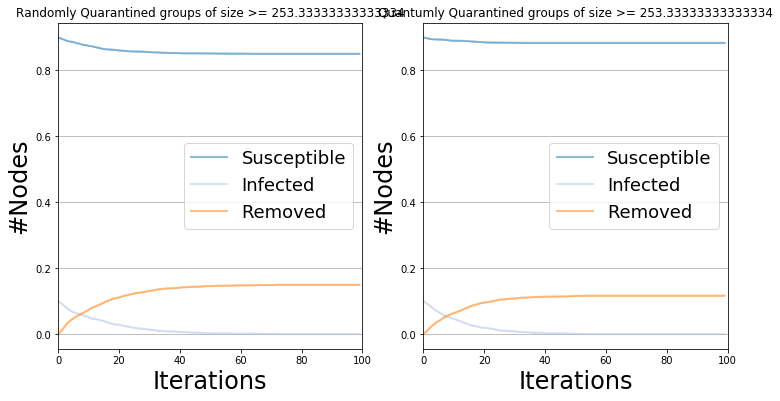

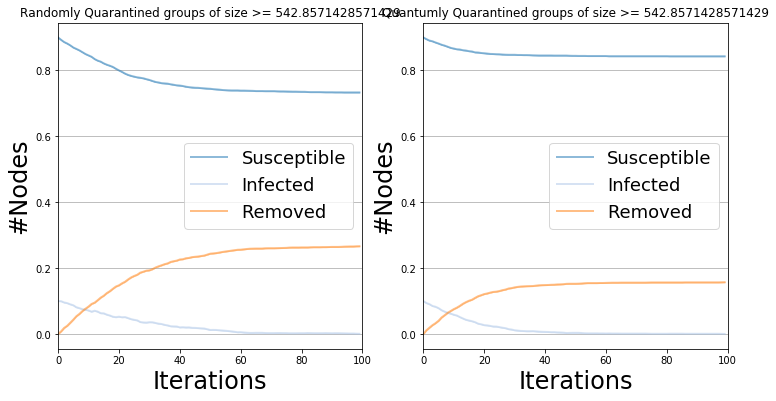

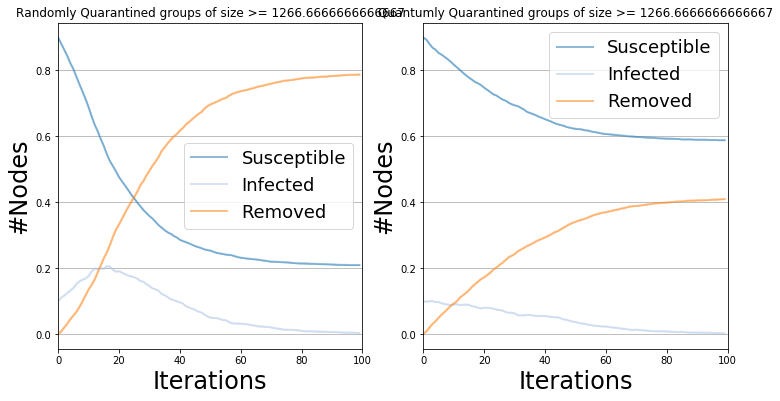

In [93]:
plot_random_quantum_comparison(cornell_approx, cornell_approx_infected, group_sizes = [250, 500, 1000], 
                               r_infect = .6/cornell_approx_avg_degree, r_recover = .1, iterations = 100)

### Weighting viral edges more:

Below we begin an exploration on to the advantages of weighting edges connecting an infected to a susceptible person higher than other edges. We have abandoned this as of now 5/1/2020 because we can simply quarantine these people a priori in the real world (provided we know they are sick)

In [264]:
# Convert an unweighted graph to a weighted graph where edges connecting a non-infected to infected node weighted more
def convert_to_weighted(G, infected):
    G_weighted = nx.Graph()
    G_edges = G.edges
    G_n = len(G_edges)
    for edge in G_edges:
        u, v = edge
        if (u in infected and v not in infected) or (v in infected and u not in infected):
            G_weighted.add_edge(u,v, weight = G_n)
        else:
            G_weighted.add_edge(u,v, weight = 1)
    return G_weighted
            
# Create QUBO dict for D-Wave to optimize
def weighted_maxcut_qubo(G):
    # The Hamiltonian is H = sum(Pauli_Z(i) x Pauli_Z(j) - I)/2
    # The eigenvalue is the negation of the edges in cut solution
    # The QUBO should be -xi-xj+2xixj, we label it as Q
    Q = defaultdict(int)
    for u, v in G.edges:
        w = G.get_edge_data(u,v)['weight']
        Q[(u,u)]+= -w
        Q[(v,v)]+= -w
        Q[(u,v)]+= 2*w
    return Q

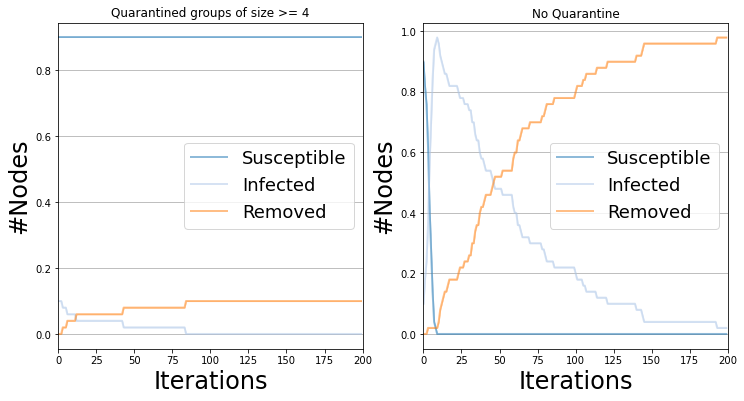

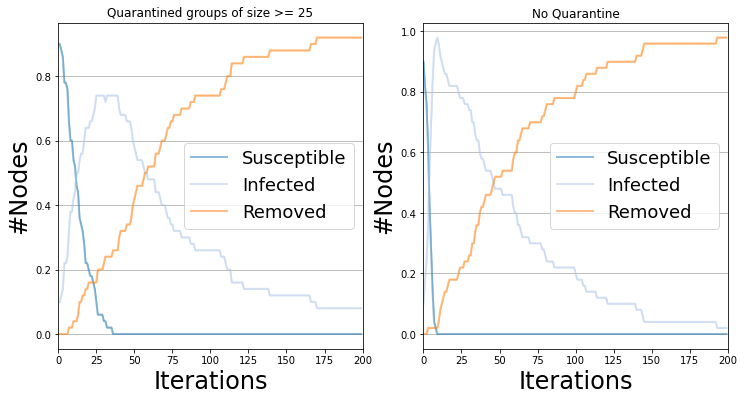

In [269]:
comm2_weighted = convert_to_weighted(comm2, comm2_infected)
plot_comparison(comm2_weighted, comm2_infected, r_infect = .04, r_recover = .02, iterations = 200, group_sizes = [4, 25])

Compare this to the plot for comm2 in the unweighted case, we are able to flatten the curve in the group of 16 case by around 10 percent. In the weighted case we flattened the curve a bit more, but this remains to be tested more and played with